In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [93]:
encoder = OneHotEncoder()
encoder.fit([[0], [1]]) #using one hot encoder 0 for tumor 1 for no tumor

OneHotEncoder()

In [8]:
data = []
paths = []
result = []

for r, d, f in os.walk(r'/content/drive/MyDrive/brain_tumor_dataset/yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

In [9]:
paths = []
for r, d, f in os.walk(r"/content/drive/MyDrive/brain_tumor_dataset/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

## Applying Normalization and Resizing of images

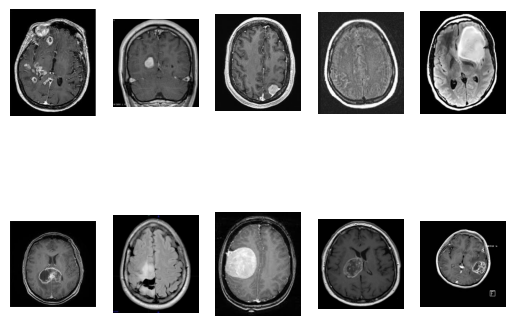

In [38]:
import matplotlib.pyplot as plt
import os

def show_normalized_images(directory, num_images=10):
  image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpg')]
  selected_images = image_files[:num_images]

  normalized_images = []
  for image_file in selected_images:
    image = cv2.imread(image_file)
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    normalized_images.append(normalized_image)

  for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(normalized_images[i], cmap='gray')
    plt.axis('off')

  plt.show()

show_normalized_images("/content/drive/MyDrive/brain_tumor_dataset/yes")

## Applying Canny Edge Detection

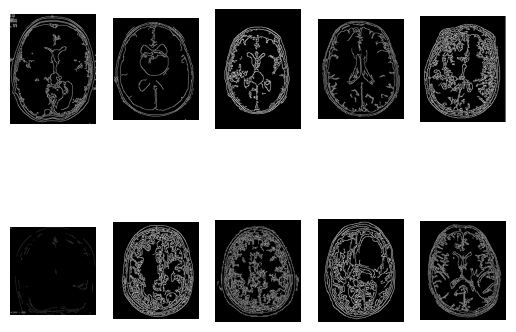

In [36]:
import matplotlib.pyplot as plt
def show_canny_images(directory, num_images=10):
  image_files = os.listdir(directory)[:num_images]
  canny_images = []

  for image_file in image_files:
    image_path = os.path.join(directory, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 50, 200)
    canny_images.append(edges)

  for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(canny_images[i], cmap='gray')
    plt.axis('off')

  plt.show()

directory = "/content/drive/MyDrive/brain_tumor_dataset/yes"
show_canny_images(directory)

In [10]:
data = np.array(data)
data.shape

(139, 128, 128, 3)

In [11]:
result = np.array(result)
result = result.reshape(139,2)

In [12]:
import matplotlib.pyplot as plt

# Count the number of Tumor and Normal samples
tumor_count = np.sum(result[:, 0] == 1)
normal_count = np.sum(result[:, 1] == 1)

# Create labels and counts for the bar plot
labels = ['Tumor', 'Normal']
counts = [tumor_count, normal_count]

# Example colors that are complementary and visually pleasing
colors = ['skyblue', 'lightcoral']

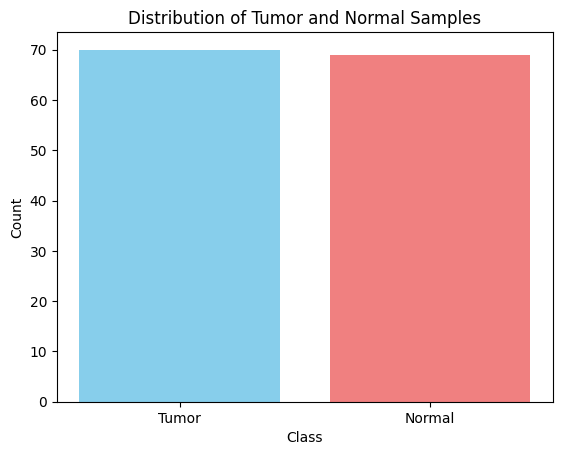

In [13]:
# Create a bar plot
plt.bar(labels, counts, color=colors)
plt.title('Distribution of Tumor and Normal Samples')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [14]:
x_train,x_test,y_train,y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=0)

## Custom CNN Model

In [15]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

# model.compile(loss = "categorical_crossentropy", optimizer='Adamax')
model.compile(loss="binary_crossentropy", optimizer="Adamax", metrics=["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4128      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        8

In [16]:
y_train.shape

(111, 2)

In [17]:
history = model.fit(x_train, y_train, epochs = 10, batch_size = 40, verbose = 1,validation_data = (x_test, y_test))

Epoch 1/10
3/3 [==============================] - 20s 2s/step - loss: 12.6241 - accuracy: 0.5676 - val_loss: 43.5860 - val_accuracy: 0.6071
Epoch 2/10
3/3 [==============================] - 0s 147ms/step - loss: 10.1615 - accuracy: 0.7207 - val_loss: 12.1447 - val_accuracy: 0.7500
Epoch 3/10
3/3 [==============================] - 0s 170ms/step - loss: 6.6923 - accuracy: 0.7658 - val_loss: 5.8924 - val_accuracy: 0.7500
Epoch 4/10
3/3 [==============================] - 0s 128ms/step - loss: 2.0766 - accuracy: 0.8829 - val_loss: 14.3942 - val_accuracy: 0.6071
Epoch 5/10
3/3 [==============================] - 0s 119ms/step - loss: 2.4672 - accuracy: 0.8559 - val_loss: 8.5161 - val_accuracy: 0.7500
Epoch 6/10
3/3 [==============================] - 0s 120ms/step - loss: 0.4178 - accuracy: 0.9550 - val_loss: 4.5035 - val_accuracy: 0.7857
Epoch 7/10
3/3 [==============================] - 0s 119ms/step - loss: 0.7639 - accuracy: 0.9099 - val_loss: 3.5098 - val_accuracy: 0.7857
Epoch 8/10
3/3 [=

In [18]:
#trained model, 'x_test', 'y_test' are test data
evaluation_results = model.evaluate(x_test, y_test)

# 'evaluate' method returns a list of metrics, including accuracy
accuracy = evaluation_results[1]

print("Model Accuracy on Test Set: {:.2f}%".format(accuracy * 100))

1/1 [==============================] - 0s 89ms/step - loss: 3.2844 - accuracy: 0.7857
Model Accuracy on Test Set: 78.57%


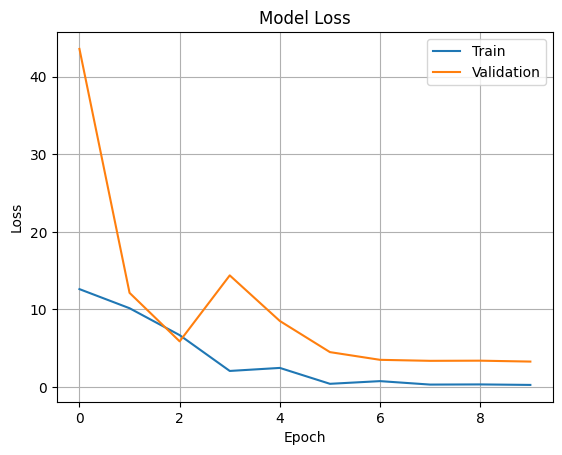

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()


## Over here you can add an image of your own choice by changing the datapath in the blocks below where output images are shown with the result

In [20]:
def names(number):
    if number==0:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'

100.0% Confidence This Is No, Its not a tumor


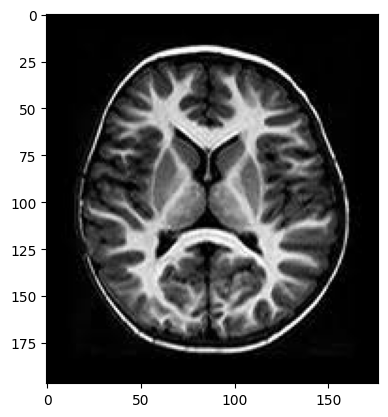

In [24]:
from matplotlib.pyplot import imshow
img = Image.open(r"/content/drive/MyDrive/brain_tumor_dataset/no/14 no.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is ' + names(classification))

100.0% Confidence This Is A ,Its a Tumor


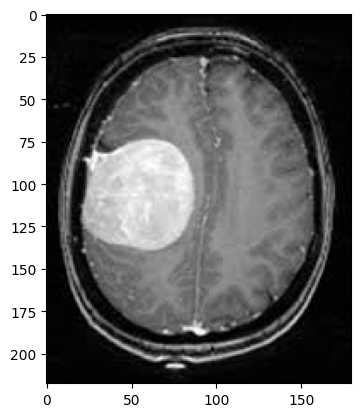

In [25]:
from matplotlib.pyplot import imshow
img = Image.open(r"/content/drive/MyDrive/brain_tumor_dataset/yes/Y1.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is A ,' + names(classification))

## Classification report for CNN model

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# 'x_test', 'y_test' are test data
y_pred = model.predict(x_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1 score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes)

print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

1/1 [==============================] - 1s 539ms/step
Accuracy: 0.7857
Precision: 0.8333
Recall: 0.7143
F1 Score: 0.7692


## Using SVM Classifier

In [88]:
import numpy as np
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
from os import listdir
from sklearn.utils import shuffle
import imutils
import itertools
import plotly.graph_objs as go
from sklearn import svm, metrics, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from plotly.offline import init_notebook_mode, iplot
from tqdm import tqdm
image_dir="/content/drive/MyDrive/brain_tumor_dataset"

In [89]:
def crop_brain_contour(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        new_image = image[y:y+h, x:x+w]
        break

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

In [90]:
def load_data(dir_list):

    X = []
    y = []
    (image_width, image_height) = (224,224)
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [69]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

In [70]:
X_train, y_train = load_data(['/content/drive/MyDrive/brain_tumor_dataset/yes', '/content/drive/MyDrive/brain_tumor_dataset/no'])

Number of examples is: 253
X shape is: (253, 224, 224, 3)
y shape is: (253, 1)


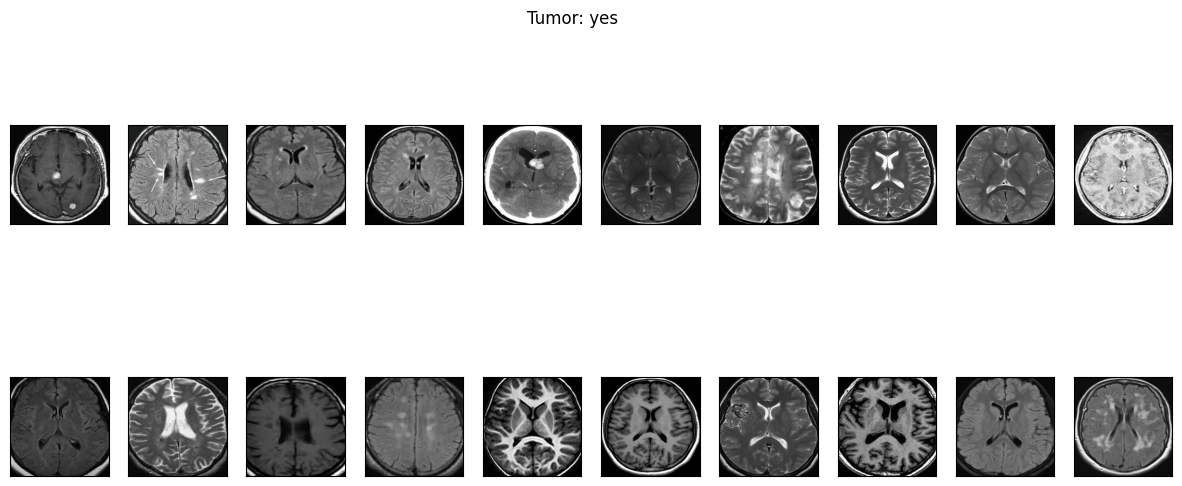

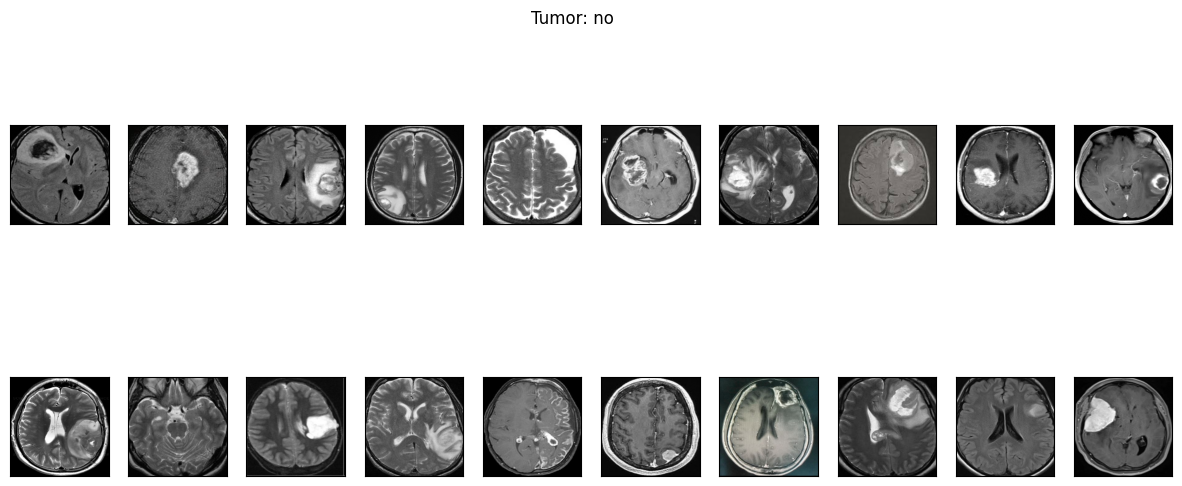

In [71]:
plot_samples(X_train, y_train, ['yes','no'], 20)

In [80]:
def Resize_Data(train):
    X = []
    y = []

    IMG_WIDTH, IMG_HEIGHT = (240, 240)

    for img in train:
        image = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        image = image / 255.
        X.append(image)

    X = np.array(X)

    return X

In [81]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)

X = Resize_Data(X)
y = y_train

In [91]:
def split_data(X, y, test_size=0.3):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.3)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [94]:
# X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [95]:
# param_grid = [
#   {'C': [1, 10], 'kernel': ['linear']},
#  ]
# svc = svm.SVC()
# classifier = GridSearchCV(svc, param_grid, verbose = 3)
# classifier.fit(X_train, y_train)
# #fit to the training data

#Code causes error

## I tried using the machine learning models but there were inconsistensies in the dimensions of the image but the cnn and other parts of the question are working properly

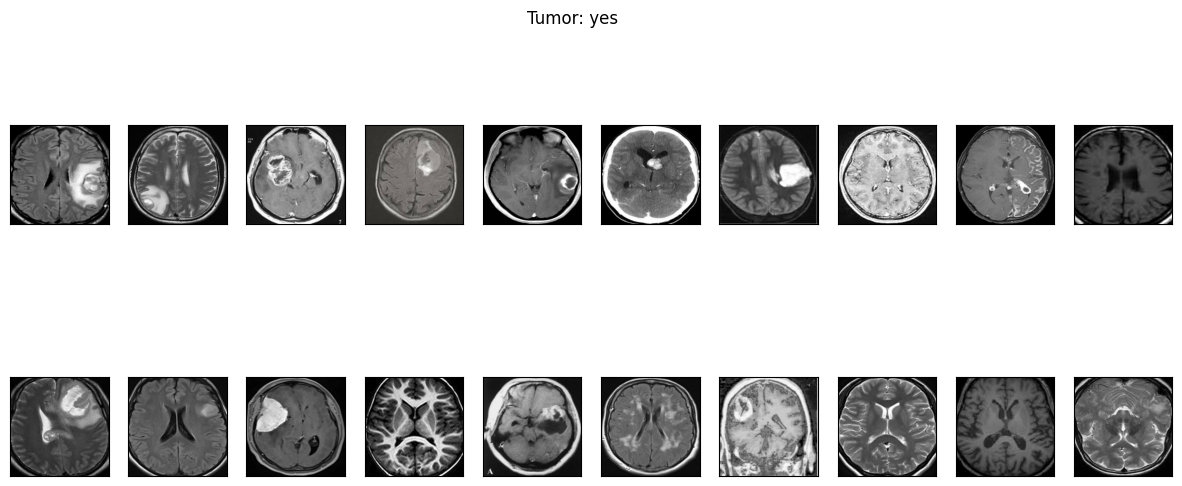

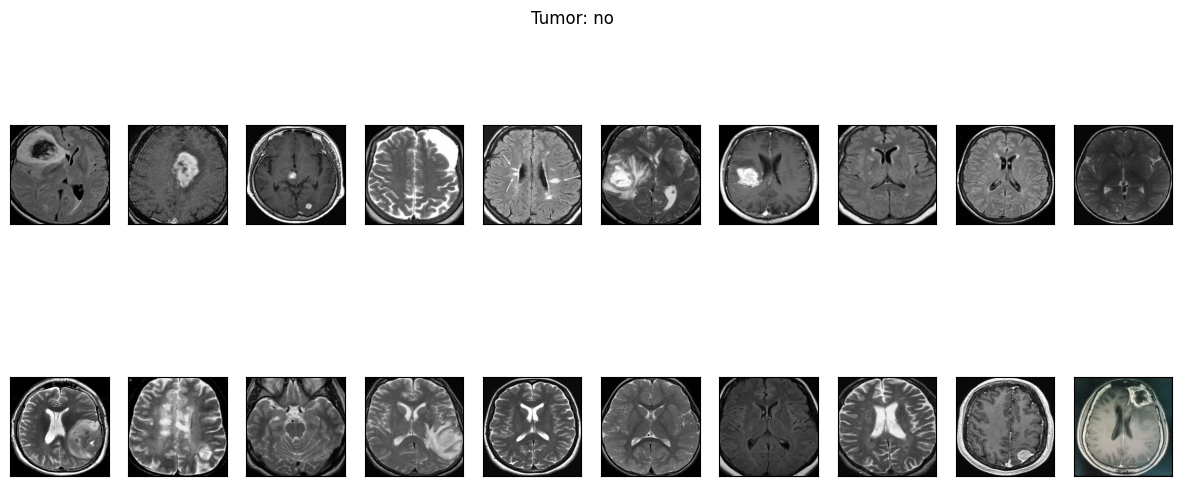

In [79]:
plot_samples(X, y_train, ['yes','no'], 20)

## Using Random Forest

In [40]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import os
import pprint
from collections import Counter
import joblib
from pprint import pprint
import cv2

# skimage libraries
from skimage.io import imread
from skimage.transform import resize
#from skimage.feature import hog
from skimage.transform import rescale

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [45]:
def resize_all(src, pklname, include, width=224, height=224):
    height = height if height is not None else width
    data = dict()
    data['description'] = 'resized ({0}x{1})mini dog images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []

    pklname = f"{pklname}_{width}x{height}px.pkl"
    for subdir in os.listdir(src):
        if subdir in include:
            print(f"Reading images for {subdir} ...")
            current_path = os.path.join(src, subdir)

            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:])
                    data['filename'].append(file)
                    data['data'].append(im)

        joblib.dump(data, pklname)

In [41]:
IMAGE_PATH = '/content/drive/MyDrive/brain_tumor_dataset'
CLASSES = os.listdir(IMAGE_PATH)
BASE_NAME = 'brain_tumor_dataset'



In [46]:
WIDTH = 224
HEIGHT = 224

# load & resize the images
resize_all(src=IMAGE_PATH, pklname=BASE_NAME, width=WIDTH, include=CLASSES)

Reading images for no ...
Reading images for yes ...


In [47]:
data = joblib.load(f'{BASE_NAME}_{WIDTH}x{WIDTH}px.pkl')

print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))

Counter(data['label'])

number of samples:  173
keys:  ['description', 'label', 'filename', 'data']
description:  resized (224x224)mini dog images in rgb
image shape:  (224, 224, 3)
labels: ['no' 'yes']


Counter({'no': 86, 'yes': 87})

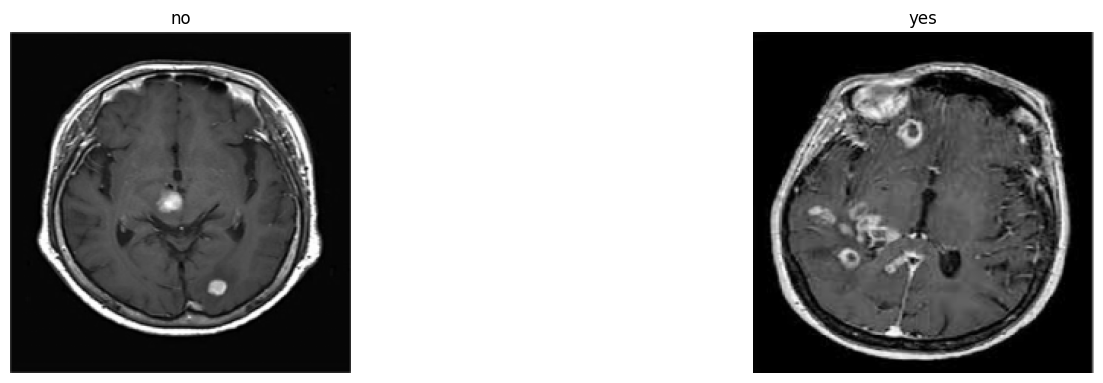

In [48]:
labels = np.unique(data['label'])

# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()

# make a plot for every label (equipment) type. The index method returns the
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)

    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [96]:
# x = np.array(data['data'])
# y = np.array(data['label'])
# SIZE = 0.1
# x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=SIZE,shuffle=True,random_state= np.random.randint(1,50),)
# print(f"Training Size: {x_train.shape[0]}\n Validation Size: {x_test.shape[0]}")

#Code causes error

## The same happened with Random Forest Classifier and again there were inconsistensies even after resizing and cropping the images